## Google Drive Setup

In [ ]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

# # Define paths to save models
# best_model_path_ijepa = '/content/drive/My Drive/best_ijepa_model.keras'
# best_model_path_linear = '/content/drive/My Drive/best_linear_probing_model.keras'


## Data Preparation

In [ ]:
import numpy as np
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


## Encoder Architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

def init_encoder(embed_dim=128):
    model = Sequential([
        layers.Conv2D(32, kernel_size=3, strides=1, padding='valid', activation=None),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=2, strides=2),

        layers.Conv2D(64, kernel_size=3, strides=1, padding='valid', activation=None),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=2, strides=2),

        layers.Conv2D(128, kernel_size=3, strides=1, padding='valid', activation=None),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=2, strides=2),

        layers.GlobalAveragePooling2D()
    ])

    return model


##Target Encoder Cloning

In [ ]:
from tensorflow.keras.models import clone_model
# Initialize encoders
context_encoder = init_encoder()
target_encoder = clone_model(context_encoder)

In [ ]:
context_encoder.build(input_shape=(None, 32, 32, 3))
target_encoder.build(input_shape=(None, 32, 32, 3))

In [ ]:
context_encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,144 (367.75 KB)

 Trainable params: 93,696 (366.00 KB)

 Non-trainable params: 448 (1.75 KB)

## Predictor Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Concatenate, Input
from tensorflow.keras.models import Model

# Input layers
context_input = Input(shape=(128,), name="context_input")
coords_input = Input(shape=(4,), name="coords_input")

# Concatenate context encoding with coordinates
x = Concatenate()([context_input, coords_input])
x = Dense(128, activation='relu')(x)
output = Dense(128, activation='relu')(x)

# Build predictor model
predictor_model = Model(inputs=[context_input, coords_input], outputs=output)


## Generate context & target blocks

In [ ]:
import numpy as np

def generate_blocks(image, block_size=4, num_target_patches=4):
    """
    Generate masked target patches and a context image with patches removed.

    Args:
        image (np.ndarray): Input image as a 2D NumPy array.
        block_size (int): Size of each block.
        num_target_patches (int): Number of target patches to generate.

    Returns:
        tuple: A tuple containing:
            - context (np.ndarray): Image with target patches removed.
            - target_patches (list[np.ndarray]): List of target patches.
    """
    # Ensure image dimensions are divisible by block_size
    image_height, image_width = image.shape[0], image.shape[1]
    assert image_height % block_size == 0, "Image height must be divisible by block_size"
    assert image_width % block_size == 0, "Image width must be divisible by block_size"
    num_rows = image_height // block_size
    num_cols = image_width // block_size

    # Calculate patch indices directly as NumPy arrays
    patch_row_indices = np.arange(0, image_height, block_size)
    patch_col_indices = np.arange(0, image_width, block_size)

    # Initialize context image
    context = image.copy()

    target_patches = []
    target_patch_coords = []
    for _ in range(num_target_patches):
        # Randomly select top-left coordinates for the patch
        top_left_y = np.random.choice(patch_row_indices)
        top_left_x = np.random.choice(patch_col_indices)

        # Randomly determine patch size within bounds
        bottom_right_y = min(
            top_left_y + np.random.choice(np.arange(2 * block_size, 8 * block_size, block_size)),
            image_height
        )
        bottom_right_x = min(
            top_left_x + np.random.choice(np.arange(2 * block_size, 8 * block_size, block_size)),
            image_width
        )

        # Extract the patch directly without copying
        target_patch = np.zeros_like(image)
        target_patch[top_left_y:bottom_right_y, top_left_x:bottom_right_x] = \
            image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]

        # Add the target patch to the list
        target_patches.append(target_patch)

        # Add target patch coords to the list
        target_patch_coords.append((top_left_y, top_left_x, bottom_right_y, bottom_right_x))

        # Remove the patch from the context image
        context[top_left_y:bottom_right_y, top_left_x:bottom_right_x] = 0

    return context, target_patches, target_patch_coords


Target coords:
(28, 8, 32, 20)
(0, 28, 20, 32)
(0, 24, 16, 32)
(28, 8, 32, 20)


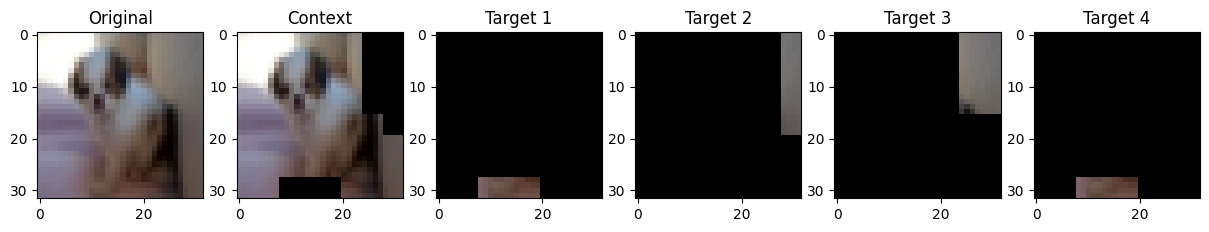

In [ ]:
import matplotlib.pyplot as plt
# Example context and target blocks

# choose a random int between 0 and 50000
random_int = np.random.randint(0, 50000)

# Generate blocks
context, target_patches, target_patch_coords = generate_blocks(x_train[random_int])

# Create a figure to show 6 images in a row
fig, axs = plt.subplots(1, 6, figsize=(15, 5))

# Show original in the first column
axs[0].imshow(x_train[random_int])
axs[0].set_title('Original')

# Show context in the second column
axs[1].imshow(context)
axs[1].set_title('Context')

# Show the targets in the rest of the columns
for i in range(2, 6):
    axs[i].imshow(target_patches[i-2])
    axs[i].set_title(f'Target {i-1}')

# Print target coords
print("Target coords:")
for coord in target_patch_coords:
    print(coord)

# Show the plot
plt.show()

In [ ]:
for layer in context_encoder.layers:
    print(f"{layer.name}: {layer.trainable}")

for layer in target_encoder.layers:
    print(f"{layer.name}: {layer.trainable}")

for layer in predictor_model.layers:
    print(f"{layer.name}: {layer.trainable}")


conv2d: True
batch_normalization: True
re_lu: True
max_pooling2d: True
conv2d_1: True
batch_normalization_1: True
re_lu_1: True
max_pooling2d_1: True
conv2d_2: True
batch_normalization_2: True
re_lu_2: True
max_pooling2d_2: True
global_average_pooling2d: True
conv2d: True
batch_normalization: True
re_lu: True
max_pooling2d: True
conv2d_1: True
batch_normalization_1: True
re_lu_1: True
max_pooling2d_1: True
conv2d_2: True
batch_normalization_2: True
re_lu_2: True
max_pooling2d_2: True
global_average_pooling2d: True
context_input: True
coords_input: True
concatenate: True
dense: True
dense_1: True


##I-JEPA Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm


# Set training parameters
epochs = 100
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = tf.keras.losses.MeanSquaredError()
initial_momentum = 0.996
final_momentum = 1.0

context_encoder.compile(optimizer=optimizer, loss=loss_fn)
target_encoder.compile(optimizer=optimizer, loss=loss_fn)
predictor_model.compile(optimizer=optimizer, loss=loss_fn)

# Training Loop
for epoch in range(epochs):
    total_loss = 0  # Track cumulative loss for the epoch
    num_batches = len(x_train) // batch_size  # Total number of batches
    current_momentum = initial_momentum + (epoch / epochs) * (final_momentum - initial_momentum)

    print(f"Epoch {epoch + 1}/{epochs}")
    with tqdm(total=num_batches, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
        for step in range(num_batches):
            # Create a batch of images
            batch_images = x_train[step * batch_size:(step + 1) * batch_size]

            # Generate context and target patches
            batch_contexts, batch_targets, batch_coords = [], [], []
            for img in batch_images:
                context, targets, coords = generate_blocks(img)
                batch_contexts.append(context)
                batch_targets.extend(targets)  # Flatten target patches
                batch_coords.extend(coords)   # Flatten coordinates

            # # Convert to numpy arrays and preprocess
            batch_contexts = np.array(batch_contexts)
            batch_targets = np.array(batch_targets)
            batch_coords = np.array(batch_coords, dtype=np.float32)

            # Encode context and target patches (silent predictions)
            batch_context_encodings = context_encoder(batch_contexts, training=True)
            batch_target_encodings = target_encoder(batch_targets, training=True)

            # Repeat context encodings to match target patches
            batch_context_encodings = tf.repeat(batch_context_encodings, len(batch_coords) // batch_size, axis=0)

            batch_coords = tf.convert_to_tensor(batch_coords, dtype=tf.float32)

            # Training step
            with tf.GradientTape() as tape:
                # Predict using predictor model
                predictions = predictor_model([batch_context_encodings, batch_coords], training=True)
                # Calculate loss
                loss = loss_fn(batch_target_encodings, predictions)

            # Print the loss for each batch
            # print(f"Batch {step}, Loss: {loss.numpy()}")
            # Compute gradients
            trainable_vars = predictor_model.trainable_variables + context_encoder.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)

            optimizer.apply_gradients(zip(gradients, trainable_vars))


            # Update loss and progress bar
            total_loss += loss.numpy()
            pbar.update(1)  # Increment progress bar

            # Update target encoder weights at the end of the epoch
            for var, target_var in zip(context_encoder.variables, target_encoder.variables):
                target_var.assign(current_momentum * target_var + (1 - current_momentum) * var)

    # Print epoch loss
    epoch_loss = total_loss / num_batches
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f},  Momentum: {current_momentum:.4f}")



Epoch 1/100


Epoch 1/100:   0%|          | 0/1562 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
Epoch 1/100: 100%|██████████| 1562/1562 [02:16<00:00, 11.47batch/s]


Epoch 1/100, Loss: 0.4495,  Momentum: 0.9960
Epoch 2/100


Epoch 2/100: 100%|██████████| 1562/1562 [02:09<00:00, 12.02batch/s]


Epoch 2/100, Loss: 0.2229,  Momentum: 0.9960
Epoch 3/100


Epoch 3/100: 100%|██████████| 1562/1562 [02:09<00:00, 12.08batch/s]


Epoch 3/100, Loss: 0.2021,  Momentum: 0.9961
Epoch 4/100


Epoch 4/100: 100%|██████████| 1562/1562 [02:09<00:00, 12.07batch/s]


Epoch 4/100, Loss: 0.1897,  Momentum: 0.9961
Epoch 5/100


Epoch 5/100: 100%|██████████| 1562/1562 [02:08<00:00, 12.12batch/s]


Epoch 5/100, Loss: 0.1844,  Momentum: 0.9962
Epoch 6/100


Epoch 6/100: 100%|██████████| 1562/1562 [02:10<00:00, 12.00batch/s]


Epoch 6/100, Loss: 0.1814,  Momentum: 0.9962
Epoch 7/100


Epoch 7/100: 100%|██████████| 1562/1562 [02:08<00:00, 12.16batch/s]


Epoch 7/100, Loss: 0.1791,  Momentum: 0.9962
Epoch 8/100


Epoch 8/100: 100%|██████████| 1562/1562 [02:09<00:00, 12.10batch/s]


Epoch 8/100, Loss: 0.1770,  Momentum: 0.9963
Epoch 9/100


Epoch 9/100: 100%|██████████| 1562/1562 [02:16<00:00, 11.41batch/s]


Epoch 9/100, Loss: 0.1758,  Momentum: 0.9963
Epoch 10/100


Epoch 10/100: 100%|██████████| 1562/1562 [02:19<00:00, 11.21batch/s]


Epoch 10/100, Loss: 0.1682,  Momentum: 0.9964
Epoch 11/100


Epoch 11/100: 100%|██████████| 1562/1562 [02:16<00:00, 11.46batch/s]


Epoch 11/100, Loss: 0.1653,  Momentum: 0.9964
Epoch 12/100


Epoch 12/100: 100%|██████████| 1562/1562 [02:10<00:00, 11.96batch/s]


Epoch 12/100, Loss: 0.1603,  Momentum: 0.9964
Epoch 13/100


Epoch 13/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.27batch/s]


Epoch 13/100, Loss: 0.1595,  Momentum: 0.9965
Epoch 14/100


Epoch 14/100: 100%|██████████| 1562/1562 [02:08<00:00, 12.15batch/s]


Epoch 14/100, Loss: 0.1587,  Momentum: 0.9965
Epoch 15/100


Epoch 15/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.30batch/s]


Epoch 15/100, Loss: 0.1580,  Momentum: 0.9966
Epoch 16/100


Epoch 16/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.24batch/s]


Epoch 16/100, Loss: 0.1575,  Momentum: 0.9966
Epoch 17/100


Epoch 17/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.24batch/s]


Epoch 17/100, Loss: 0.1570,  Momentum: 0.9966
Epoch 18/100


Epoch 18/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.23batch/s]


Epoch 18/100, Loss: 0.1565,  Momentum: 0.9967
Epoch 19/100


Epoch 19/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.27batch/s]


Epoch 19/100, Loss: 0.1530,  Momentum: 0.9967
Epoch 20/100


Epoch 20/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.26batch/s]


Epoch 20/100, Loss: 0.1504,  Momentum: 0.9968
Epoch 21/100


Epoch 21/100: 100%|██████████| 1562/1562 [02:08<00:00, 12.20batch/s]


Epoch 21/100, Loss: 0.1505,  Momentum: 0.9968
Epoch 22/100


Epoch 22/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.28batch/s]


Epoch 22/100, Loss: 0.1501,  Momentum: 0.9968
Epoch 23/100


Epoch 23/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.25batch/s]


Epoch 23/100, Loss: 0.1494,  Momentum: 0.9969
Epoch 24/100


Epoch 24/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.32batch/s]


Epoch 24/100, Loss: 0.1491,  Momentum: 0.9969
Epoch 25/100


Epoch 25/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.26batch/s]


Epoch 25/100, Loss: 0.1493,  Momentum: 0.9970
Epoch 26/100


Epoch 26/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.29batch/s]


Epoch 26/100, Loss: 0.1488,  Momentum: 0.9970
Epoch 27/100


Epoch 27/100: 100%|██████████| 1562/1562 [02:08<00:00, 12.12batch/s]


Epoch 27/100, Loss: 0.1484,  Momentum: 0.9970
Epoch 28/100


Epoch 28/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.26batch/s]


Epoch 28/100, Loss: 0.1484,  Momentum: 0.9971
Epoch 29/100


Epoch 29/100: 100%|██████████| 1562/1562 [02:08<00:00, 12.14batch/s]


Epoch 29/100, Loss: 0.1479,  Momentum: 0.9971
Epoch 30/100


Epoch 30/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.24batch/s]


Epoch 30/100, Loss: 0.1476,  Momentum: 0.9972
Epoch 31/100


Epoch 31/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.33batch/s]


Epoch 31/100, Loss: 0.1470,  Momentum: 0.9972
Epoch 32/100


Epoch 32/100: 100%|██████████| 1562/1562 [02:08<00:00, 12.18batch/s]


Epoch 32/100, Loss: 0.1448,  Momentum: 0.9972
Epoch 33/100


Epoch 33/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.32batch/s]


Epoch 33/100, Loss: 0.1444,  Momentum: 0.9973
Epoch 34/100


Epoch 34/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.25batch/s]


Epoch 34/100, Loss: 0.1442,  Momentum: 0.9973
Epoch 35/100


Epoch 35/100: 100%|██████████| 1562/1562 [02:08<00:00, 12.20batch/s]


Epoch 35/100, Loss: 0.1437,  Momentum: 0.9974
Epoch 36/100


Epoch 36/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.23batch/s]


Epoch 36/100, Loss: 0.1437,  Momentum: 0.9974
Epoch 37/100


Epoch 37/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.29batch/s]


Epoch 37/100, Loss: 0.1432,  Momentum: 0.9974
Epoch 38/100


Epoch 38/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.36batch/s]


Epoch 38/100, Loss: 0.1432,  Momentum: 0.9975
Epoch 39/100


Epoch 39/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.38batch/s]


Epoch 39/100, Loss: 0.1430,  Momentum: 0.9975
Epoch 40/100


Epoch 40/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.37batch/s]


Epoch 40/100, Loss: 0.1430,  Momentum: 0.9976
Epoch 41/100


Epoch 41/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.36batch/s]


Epoch 41/100, Loss: 0.1397,  Momentum: 0.9976
Epoch 42/100


Epoch 42/100: 100%|██████████| 1562/1562 [02:05<00:00, 12.40batch/s]


Epoch 42/100, Loss: 0.1391,  Momentum: 0.9976
Epoch 43/100


Epoch 43/100: 100%|██████████| 1562/1562 [02:05<00:00, 12.42batch/s]


Epoch 43/100, Loss: 0.1390,  Momentum: 0.9977
Epoch 44/100


Epoch 44/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.36batch/s]


Epoch 44/100, Loss: 0.1387,  Momentum: 0.9977
Epoch 45/100


Epoch 45/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.21batch/s]


Epoch 45/100, Loss: 0.1389,  Momentum: 0.9978
Epoch 46/100


Epoch 46/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.30batch/s]


Epoch 46/100, Loss: 0.1388,  Momentum: 0.9978
Epoch 47/100


Epoch 47/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.23batch/s]


Epoch 47/100, Loss: 0.1386,  Momentum: 0.9978
Epoch 48/100


Epoch 48/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.22batch/s]


Epoch 48/100, Loss: 0.1384,  Momentum: 0.9979
Epoch 49/100


Epoch 49/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.25batch/s]


Epoch 49/100, Loss: 0.1381,  Momentum: 0.9979
Epoch 50/100


Epoch 50/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.27batch/s]


Epoch 50/100, Loss: 0.1383,  Momentum: 0.9980
Epoch 51/100


Epoch 51/100: 100%|██████████| 1562/1562 [02:08<00:00, 12.19batch/s]


Epoch 51/100, Loss: 0.1379,  Momentum: 0.9980
Epoch 52/100


Epoch 52/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.28batch/s]


Epoch 52/100, Loss: 0.1378,  Momentum: 0.9980
Epoch 53/100


Epoch 53/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.21batch/s]


Epoch 53/100, Loss: 0.1380,  Momentum: 0.9981
Epoch 54/100


Epoch 54/100: 100%|██████████| 1562/1562 [02:08<00:00, 12.19batch/s]


Epoch 54/100, Loss: 0.1377,  Momentum: 0.9981
Epoch 55/100


Epoch 55/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.25batch/s]


Epoch 55/100, Loss: 0.1378,  Momentum: 0.9982
Epoch 56/100


Epoch 56/100: 100%|██████████| 1562/1562 [02:08<00:00, 12.17batch/s]


Epoch 56/100, Loss: 0.1374,  Momentum: 0.9982
Epoch 57/100


Epoch 57/100: 100%|██████████| 1562/1562 [02:08<00:00, 12.20batch/s]


Epoch 57/100, Loss: 0.1374,  Momentum: 0.9982
Epoch 58/100


Epoch 58/100: 100%|██████████| 1562/1562 [02:09<00:00, 12.08batch/s]


Epoch 58/100, Loss: 0.1373,  Momentum: 0.9983
Epoch 59/100


Epoch 59/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.30batch/s]


Epoch 59/100, Loss: 0.1372,  Momentum: 0.9983
Epoch 60/100


Epoch 60/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.29batch/s]


Epoch 60/100, Loss: 0.1373,  Momentum: 0.9984
Epoch 61/100


Epoch 61/100: 100%|██████████| 1562/1562 [02:08<00:00, 12.13batch/s]


Epoch 61/100, Loss: 0.1369,  Momentum: 0.9984
Epoch 62/100


Epoch 62/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.26batch/s]


Epoch 62/100, Loss: 0.1370,  Momentum: 0.9984
Epoch 63/100


Epoch 63/100: 100%|██████████| 1562/1562 [02:08<00:00, 12.19batch/s]


Epoch 63/100, Loss: 0.1371,  Momentum: 0.9985
Epoch 64/100


Epoch 64/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.30batch/s]


Epoch 64/100, Loss: 0.1365,  Momentum: 0.9985
Epoch 65/100


Epoch 65/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.33batch/s]


Epoch 65/100, Loss: 0.1366,  Momentum: 0.9986
Epoch 66/100


Epoch 66/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.36batch/s]


Epoch 66/100, Loss: 0.1368,  Momentum: 0.9986
Epoch 67/100


Epoch 67/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.35batch/s]


Epoch 67/100, Loss: 0.1364,  Momentum: 0.9986
Epoch 68/100


Epoch 68/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.32batch/s]


Epoch 68/100, Loss: 0.1365,  Momentum: 0.9987
Epoch 69/100


Epoch 69/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.33batch/s]


Epoch 69/100, Loss: 0.1365,  Momentum: 0.9987
Epoch 70/100


Epoch 70/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.30batch/s]


Epoch 70/100, Loss: 0.1366,  Momentum: 0.9988
Epoch 71/100


Epoch 71/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.31batch/s]


Epoch 71/100, Loss: 0.1362,  Momentum: 0.9988
Epoch 72/100


Epoch 72/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.32batch/s]


Epoch 72/100, Loss: 0.1363,  Momentum: 0.9988
Epoch 73/100


Epoch 73/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.33batch/s]


Epoch 73/100, Loss: 0.1361,  Momentum: 0.9989
Epoch 74/100


Epoch 74/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.39batch/s]


Epoch 74/100, Loss: 0.1361,  Momentum: 0.9989
Epoch 75/100


Epoch 75/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.35batch/s]


Epoch 75/100, Loss: 0.1360,  Momentum: 0.9990
Epoch 76/100


Epoch 76/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.39batch/s]


Epoch 76/100, Loss: 0.1359,  Momentum: 0.9990
Epoch 77/100


Epoch 77/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.39batch/s]


Epoch 77/100, Loss: 0.1359,  Momentum: 0.9990
Epoch 78/100


Epoch 78/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.38batch/s]


Epoch 78/100, Loss: 0.1360,  Momentum: 0.9991
Epoch 79/100


Epoch 79/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.39batch/s]


Epoch 79/100, Loss: 0.1358,  Momentum: 0.9991
Epoch 80/100


Epoch 80/100: 100%|██████████| 1562/1562 [02:05<00:00, 12.40batch/s]


Epoch 80/100, Loss: 0.1361,  Momentum: 0.9992
Epoch 81/100


Epoch 81/100: 100%|██████████| 1562/1562 [02:05<00:00, 12.42batch/s]


Epoch 81/100, Loss: 0.1358,  Momentum: 0.9992
Epoch 82/100


Epoch 82/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.39batch/s]


Epoch 82/100, Loss: 0.1356,  Momentum: 0.9992
Epoch 83/100


Epoch 83/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.36batch/s]


Epoch 83/100, Loss: 0.1357,  Momentum: 0.9993
Epoch 84/100


Epoch 84/100: 100%|██████████| 1562/1562 [02:05<00:00, 12.41batch/s]


Epoch 84/100, Loss: 0.1355,  Momentum: 0.9993
Epoch 85/100


Epoch 85/100: 100%|██████████| 1562/1562 [02:05<00:00, 12.41batch/s]


Epoch 85/100, Loss: 0.1355,  Momentum: 0.9994
Epoch 86/100


Epoch 86/100: 100%|██████████| 1562/1562 [02:05<00:00, 12.41batch/s]


Epoch 86/100, Loss: 0.1355,  Momentum: 0.9994
Epoch 87/100


Epoch 87/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.39batch/s]


Epoch 87/100, Loss: 0.1351,  Momentum: 0.9994
Epoch 88/100


Epoch 88/100: 100%|██████████| 1562/1562 [02:07<00:00, 12.24batch/s]


Epoch 88/100, Loss: 0.1355,  Momentum: 0.9995
Epoch 89/100


Epoch 89/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.31batch/s]


Epoch 89/100, Loss: 0.1355,  Momentum: 0.9995
Epoch 90/100


Epoch 90/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.36batch/s]


Epoch 90/100, Loss: 0.1352,  Momentum: 0.9996
Epoch 91/100


Epoch 91/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.39batch/s]


Epoch 91/100, Loss: 0.1354,  Momentum: 0.9996
Epoch 92/100


Epoch 92/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.36batch/s]


Epoch 92/100, Loss: 0.1352,  Momentum: 0.9996
Epoch 93/100


Epoch 93/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.35batch/s]


Epoch 93/100, Loss: 0.1351,  Momentum: 0.9997
Epoch 94/100


Epoch 94/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.36batch/s]


Epoch 94/100, Loss: 0.1349,  Momentum: 0.9997
Epoch 95/100


Epoch 95/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.39batch/s]


Epoch 95/100, Loss: 0.1349,  Momentum: 0.9998
Epoch 96/100


Epoch 96/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.37batch/s]


Epoch 96/100, Loss: 0.1351,  Momentum: 0.9998
Epoch 97/100


Epoch 97/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.32batch/s]


Epoch 97/100, Loss: 0.1349,  Momentum: 0.9998
Epoch 98/100


Epoch 98/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.39batch/s]


Epoch 98/100, Loss: 0.1347,  Momentum: 0.9999
Epoch 99/100


Epoch 99/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.39batch/s]


Epoch 99/100, Loss: 0.1349,  Momentum: 0.9999
Epoch 100/100


Epoch 100/100: 100%|██████████| 1562/1562 [02:06<00:00, 12.32batch/s]

Epoch 100/100, Loss: 0.1347,  Momentum: 1.0000


In [ ]:
batch_images = x_train[step * batch_size:(step + 1) * batch_size]

# Generate context and target patches
batch_contexts, batch_targets, batch_coords = [], [], []
for img in batch_images:
    context, targets, coords = generate_blocks(img)
    batch_contexts.append(context)
    batch_targets.extend(targets)  # Flatten target patches
    batch_coords.extend(coords)   # Flatten coordinates


In [ ]:
context_encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 348,610 (1.33 MB)

 Trainable params: 93,696 (366.00 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 254,466 (994.01 KB)

In [ ]:
target_encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 348,610 (1.33 MB)

 Trainable params: 93,696 (366.00 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 254,466 (994.01 KB)

In [ ]:
predictor_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ context_input             │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ coords_input (InputLayer) │ (None, 4)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 132)            │              0 │ context_input[0][0],   │
│                           │                        │                │ coords_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         17,024 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         16,512 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 288,002 (1.10 MB)

 Trainable params: 33,536 (131.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 254,466 (994.01 KB)

In [ ]:
m = target_encoder.predict(x_train[0:1])
n = context_encoder.predict(x_train[0:1])

print(m==n)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
[[False False False False False False False False False False False False
  False  True False False False False False False False False False False
  False  True False  True False  True False False False False False False
  False False False False False False False  True False False False False
  False False False False False False False False False False False  True
  False False False  True False False False False False False False False
  False  True False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False]]


## Linear Probing

In [ ]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

# Freeze the target encoder
for layer in target_encoder.layers:
    layer.trainable = False

# Build linear probing model
def build_linear_probe_model(encoder, num_classes):
    # Input for image
    input_layer = Input(shape=(32, 32, 3), name="image_input")

    # Pass input through the frozen encoder
    x = encoder(input_layer)

    # Add linear classification head
    output_layer = Dense(num_classes, activation="softmax", name="classification_head")(x)

    # Build model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Create the linear probing model
num_classes = 10  # CIFAR-10 has 10 classes
linear_probe_model = build_linear_probe_model(target_encoder, num_classes)


In [ ]:
# Compile the model
linear_probe_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Train the linear probing model
history = linear_probe_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=64,
    epochs=40
)


Epoch 1/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2294 - loss: 0.0000e+00 - val_accuracy: 0.3447 - val_loss: 0.0000e+00
Epoch 2/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3557 - loss: 0.0000e+00 - val_accuracy: 0.3850 - val_loss: 0.0000e+00
Epoch 3/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3938 - loss: 0.0000e+00 - val_accuracy: 0.4098 - val_loss: 0.0000e+00
Epoch 4/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4114 - loss: 0.0000e+00 - val_accuracy: 0.4193 - val_loss: 0.0000e+00
Epoch 5/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4191 - loss: 0.0000e+00 - val_accuracy: 0.4306 - val_loss: 0.0000e+00
Epoch 6/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4289 - loss: 0.0000e+00 - val_accuracy: 0.4303 - val_loss: 0.0000e+00
Epoch 7/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4310 - loss: 0.0000e+00 - val_accuracy: 0.4393 - val_loss: 0.0000e+00
Epoch 8/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/s

In [ ]:
linear_probe_model.predict(x_train[0:2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


array([[0.00256538, 0.00110448, 0.0305095 , 0.15591443, 0.1572327 ,
        0.5023187 , 0.02937969, 0.11629874, 0.0015472 , 0.00312919],
       [0.28258216, 0.6101405 , 0.01054901, 0.00196946, 0.00421772,
        0.00200002, 0.00286383, 0.00306283, 0.01490534, 0.06770904]],
      dtype=float32)

In [ ]:
# Evaluate on the test set
test_accuracy = linear_probe_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4578 - loss: 0.0000e+00
Test Accuracy: [0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 0.0, 0.4512999951839447, 0.0, 

In [ ]:
simple_model = init_encoder()
simple_model.add(layers.Dense(10, activation='softmax'))

In [ ]:
simple_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
simple_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=64,
    epochs=40
)

Epoch 1/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4720 - loss: 1.4825 - val_accuracy: 0.4655 - val_loss: 1.4814
Epoch 2/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6605 - loss: 0.9859 - val_accuracy: 0.4829 - val_loss: 1.5913
Epoch 3/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7136 - loss: 0.8350 - val_accuracy: 0.6459 - val_loss: 1.0215
Epoch 4/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7501 - loss: 0.7321 - val_accuracy: 0.6500 - val_loss: 1.0779
Epoch 5/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7705 - loss: 0.6695 - val_accuracy: 0.6730 - val_loss: 0.9618
Epoch 6/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8002 - loss: 0.6005 - val_accuracy: 0.6574 - val_loss: 1.0245
Epoch 7/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8118 - loss: 0.5562 - val_accuracy: 0.6985 - val_loss: 0.8966
Epoch 8/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8257 - loss: 0.5162 - val_accuracy: 